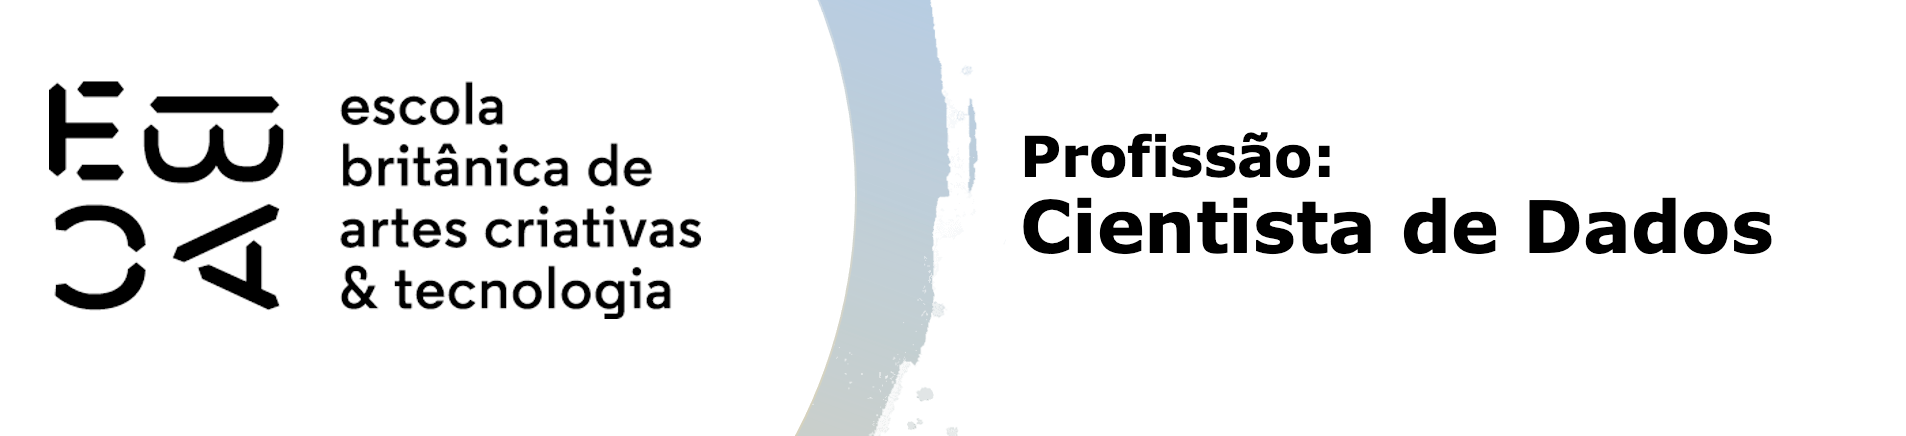

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Importando as bibliotecas necesárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from pycaret.classification import *

In [2]:
# Importando a base de dados
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Convertendo a coluna 'data_ref' para o formato datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenando o dataframe por 'data_ref'
df = df.sort_values(by='data_ref')

# Identificando os três últimos meses
three_last_months = df['data_ref'].unique()[-3:]

# Separando os dados em treino e validação (oot)
train_df = df[~df['data_ref'].isin(three_last_months)]
oot_df = df[df['data_ref'].isin(three_last_months)]

# Removendo as colunas 'data_ref' e 'index' para a modelagem
train_df = train_df.drop(columns=['data_ref', 'index'])
oot_df = oot_df.drop(columns=['data_ref', 'index'])

print(train_df.head())
print(oot_df.head())

      sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0        F                N               N           0   Empresário   
33328    M                S               S           1  Assalariado   
33329    F                N               N           0  Assalariado   
33330    M                N               S           1  Assalariado   
33331    F                N               S           1  Assalariado   

                  educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                    Médio     Solteiro            Casa     43       6.873973   
33328                Médio       Casado            Casa     41       8.134247   
33329    Superior completo     Solteiro            Casa     26       1.424658   
33330  Superior incompleto       Casado            Casa     37      15.449315   
33331                Médio       Casado            Casa     30       0.369863   

       qt_pessoas_residencia     renda    mau  
0                        1.0   2

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Base do número de linhas
print(f"Total de linhas: {len(df)}")

Total de linhas: 750000


In [5]:
# Número de linhas para cada mês em data_ref
print(df['data_ref'].value_counts())

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [6]:
# Descritiva univariada para variáveis qualitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

for var in qualitativas:
    print(f"\nDescritiva para {var}:")
    print(df[var].value_counts())
    print(df[var].value_counts(normalize=True) * 100)


Descritiva para sexo:
F    504580
M    245420
Name: sexo, dtype: int64
F    67.277333
M    32.722667
Name: sexo, dtype: float64

Descritiva para posse_de_veiculo:
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64
N    61.060533
S    38.939467
Name: posse_de_veiculo, dtype: float64

Descritiva para posse_de_imovel:
S    503692
N    246308
Name: posse_de_imovel, dtype: int64
S    67.158933
N    32.841067
Name: posse_de_imovel, dtype: float64

Descritiva para tipo_renda:
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: tipo_renda, dtype: int64
Assalariado         51.432000
Empresário          23.028267
Pensionista         16.835333
Servidor público     8.656267
Bolsista             0.048133
Name: tipo_renda, dtype: float64

Descritiva para educacao:
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação      

In [7]:
# Descritiva univariada para variáveis quantitativas
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for var in quantitativas:
    print(f"\nDescritiva para {var}:")
    print(df[var].describe())


Descritiva para qtd_filhos:
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64

Descritiva para idade:
count    750000.000000
mean         43.804733
std          11.229868
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64

Descritiva para tempo_emprego:
count    624043.000000
mean          7.748574
std           6.687455
min           0.117808
25%           3.049315
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64

Descritiva para qt_pessoas_residencia:
count    750000.000000
mean          2.212241
std           0.903428
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float6

<div style="background-color: #FFF1E0">

# Interpretação de algumas das informações acima

**Geral:** A base de dados contém um total de 750.000 registros.<br>
**data_ref:** Existem registros mensais de janeiro de 2015 até março de 2016, com 50.000 registros em cada mês.
### Variáveis qualitativas:
**sexo:** A maioria dos registros é de mulheres (67,28%).<br>
**posse_de_veiculo:** A maioria não possui veículo (61,06%).<br>
**posse_de_imovel:** A maioria possui imóvel (67,16%).<br>
**tipo_renda:** A maioria é assalariada (51,43%).<br>
**educacao:** A maioria possui ensino médio (67,58%).<br>
**estado_civil:** A maioria é casada (70,20%).<br>
**tipo_residencia:** A esmagadora maioria reside em casas (89,91%).<br>
**mau:** A maioria (92,18%) não é inadimplente.
### Variáveis quantitativas:
**qtd_filhos:** A média de filhos é de aproximadamente 0,43, com a maioria das pessoas (75% delas) tendo 0 ou 1 filho.<br>
**idade:** A média de idade é de aproximadamente 43,8 anos.<br>
**tempo_emprego:** A média de tempo de emprego é de aproximadamente 7,75 anos. Nota para contagem que é de 624.043, indicando que temos dados faltantes para essa variável.<br>
**qt_pessoas_residencia:** Em média, há 2,21 pessoas por residência.<br>
**renda:** A renda média é de aproximadamente 23.238,54. Entretanto, o desvio padrão é alto, indicando uma ampla dispersão nos valores. A renda máxima é substancialmente alta, o que pode indicar a presença de outliers.
    
</div>

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

### Variáveis Qualitativas

In [8]:
# Tabela de contingência entre 'mau' e 'sexo'
contingency_sex = pd.crosstab(df['sexo'], df['mau'])

# Proporção de inadimplentes por sexo
contingency_sex['Proporção de Inadimplentes'] = contingency_sex[True] / (contingency_sex[True] + contingency_sex[False])
print(contingency_sex)

mau    False   True  Proporção de Inadimplentes
sexo                                           
F     463950  40630                    0.080522
M     227407  18013                    0.073397


In [9]:
# Tabela de contingência entre 'mau' e 'posse_de_veiculo'
contingency_sex = pd.crosstab(df['posse_de_veiculo'], df['mau'])

# Proporção de inadimplentes por sexo
contingency_sex['Proporção de Inadimplentes'] = contingency_sex[True] / (contingency_sex[True] + contingency_sex[False])
print(contingency_sex)

mau                False   True  Proporção de Inadimplentes
posse_de_veiculo                                           
N                 421872  36082                    0.078790
S                 269485  22561                    0.077252


In [10]:
# Tabela de contingência entre 'mau' e 'posse_de_imovel'
contingency_sex = pd.crosstab(df['posse_de_imovel'], df['mau'])

# Proporção de inadimplentes por sexo
contingency_sex['Proporção de Inadimplentes'] = contingency_sex[True] / (contingency_sex[True] + contingency_sex[False])
print(contingency_sex)

mau               False   True  Proporção de Inadimplentes
posse_de_imovel                                           
N                224515  21793                    0.088479
S                466842  36850                    0.073160


### Variáveis Quantitativas

In [11]:
# Estatísticas descritivas segmentadas por 'mau' e 'idade'
stats_idade = df.groupby('mau')['idade'].describe()
print(stats_idade)

          count       mean        std   min   25%   50%   75%   max
mau                                                                
False  691357.0  43.896274  11.193997  22.0  35.0  43.0  53.0  68.0
True    58643.0  42.725543  11.590152  22.0  33.0  41.0  52.0  68.0


In [12]:
# Estatísticas descritivas segmentadas por 'mau' e 'qtd_filhos'
stats_idade = df.groupby('mau')['qtd_filhos'].describe()
print(stats_idade)

          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  691357.0  0.431739  0.737456  0.0  0.0  0.0  1.0  14.0
True    58643.0  0.451068  0.761465  0.0  0.0  0.0  1.0  14.0


In [13]:
# Estatísticas descritivas segmentadas por 'mau' e 'tempo_emprego'
stats_idade = df.groupby('mau')['tempo_emprego'].describe()
print(stats_idade)

          count      mean       std       min       25%       50%        75%  \
mau                                                                            
False  575806.0  8.004300  6.807303  0.117808  3.219178  6.345205  10.556164   
True    48237.0  4.695965  3.913739  0.117808  1.715068  3.854795   6.621918   

             max  
mau               
False  42.906849  
True   42.906849  


In [14]:
# Estatísticas descritivas segmentadas por 'mau' e 'qt_pessoas_residencia'
stats_idade = df.groupby('mau')['qt_pessoas_residencia'].describe()
print(stats_idade)

          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  691357.0  2.211221  0.901365  1.0  2.0  2.0  3.0  15.0
True    58643.0  2.224272  0.927327  1.0  2.0  2.0  3.0  15.0


In [15]:
# Estatísticas descritivas segmentadas por 'mau' e 'renda'
stats_idade = df.groupby('mau')['renda'].describe()
print(stats_idade)

          count          mean           std     min       25%      50%  \
mau                                                                      
False  691357.0  24804.689618  82154.474316  113.36  3896.300  8602.87   
True    58643.0   4774.871007   9612.302738  107.67  1301.785  2507.28   

            75%         max  
mau                          
False  19688.06  4083986.22  
True    5133.16   989799.47  


<div style="background-color: #FFF1E0">

# Interpretação dos dados acima
## Sexo e inadimplência:

### Mulheres:
**Não inadimplentes:** 463,950<br>
**Inadimplentes:** 40,630<br>
**Proporção de inadimplentes:** 8.05%<br>
### Homens:
**Não inadimplentes:** 227,407<br>
**Inadimplentes:** 18,013<br>
**Proporção de inadimplentes:** 7.34%<br>
**Interpretação:** Há uma proporção ligeiramente maior de mulheres inadimplentes (8.05%) em comparação com os homens (7.34%). No entanto, na análise univariada, vimos que havia mais mulheres na amostra.

## Posse de veículo e inadimplência:

### Sem veículo:

**Não inadimplentes:** 421,872<br>
**Inadimplentes:** 36,082<br>
**Proporção de inadimplentes:** 7.88%

### Com veículo:

**Não inadimplentes:** 269,485<br>
**Inadimplentes:** 22,561<br>
**Proporção de inadimplentes:** 7.73%<br>
**Interpretação:** Não há uma diferença significativa entre possuir um veículo e ser inadimplente. Ambos os grupos possuem proporções de inadimplência muito semelhantes.

## 3. Idade e inadimplência:

### Não inadimplentes:
**Idade média:** 43.89 anos
### Inadimplentes:
**Idade média:** 42.73 anos<br>
**Interpretação:** Os inadimplentes tendem a ser mais jovens do que os não inadimplentes.

## 4. Renda e inadimplência:

### Não inadimplentes:
**Renda média:** 24,804.69<br>
**Renda máxima:** 4,083,986.22<br>
**Renda mínima:** 113.36
### Inadimplentes:
**Renda média:** 4,774.87<br>
**Renda máxima:** 989,799.47<br>
**Renda mínima:** 107.67<br>
**Interpretação:** Há uma grande diferença na renda média entre os inadimplentes e os não inadimplentes. Os inadimplentes têm uma renda média menor do que os não inadimplentes.<br><br>

De forma geral, os insights desses dados sugerem que há certas características que podem ser associadas à inadimplência, como renda e idade. No entanto, outras variáveis, como posse de veículo, não mostram uma diferença significativa na propensão à inadimplência.

</div>

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratamento de Valores Missing e Outliers

In [16]:
# Tratando valores missing
for coluna in df.columns:
    if df[coluna].dtype == 'object':  # Se for categórica
        moda = df[coluna].mode()[0]
        df[coluna].fillna(moda, inplace=True)
    else:  # Se for numérica
        media = df[coluna].mean()
        df[coluna].fillna(media, inplace=True)

# Identificando e tratando outliers
for coluna in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inferior = Q1 - 1.5 * IQR
    lim_superior = Q3 + 1.5 * IQR
    df[coluna] = df[coluna].apply(lambda x: Q3 if x > lim_superior else (Q1 if x < lim_inferior else x))

### Identificando colunas com potenciais zeros estruturais

In [17]:
# Listando colunas numéricas
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Contando zeros para cada coluna numérica
colunas_com_zeros = {coluna: (df[coluna] == 0).sum() for coluna in colunas_numericas if (df[coluna] == 0).sum() > 0}

print(colunas_com_zeros)

{'index': 53, 'qtd_filhos': 517331}


In [18]:
# Dropando a coluna index
df = df.drop('index', axis=1)

In [19]:
# Agrupando categorias para 'tipo_renda'
df['tipo_renda'] = df['tipo_renda'].replace({'Bolsista': 'Outros'})

# Agrupando categorias para 'educacao'
df['educacao'] = df['educacao'].replace({
    'Pós graduação': 'Outros',
    'Fundamental': 'Outros',
    'Superior incompleto': 'Outros'
})

# Agrupando categorias para 'estado_civil'
df['estado_civil'] = df['estado_civil'].replace({
    'Viúvo': 'Outros',
    'Separado': 'Outros',
    'União': 'Outros'
})

# Agrupando categorias para 'tipo_residencia'
df['tipo_residencia'] = df['tipo_residencia'].replace({
    'Estúdio': 'Outros',
    'Comunitário': 'Outros',
    'Aluguel': 'Outros',
    'Governamental': 'Outros'
})

### Visualizando a Distribuição das Novas Categorias

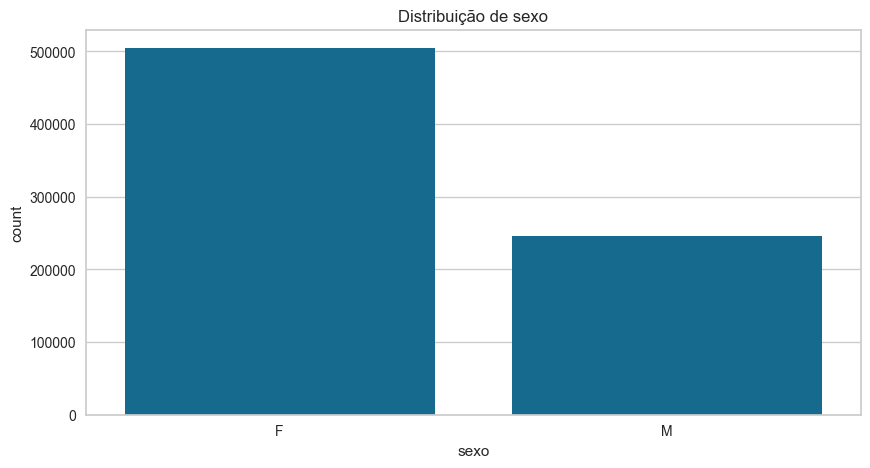

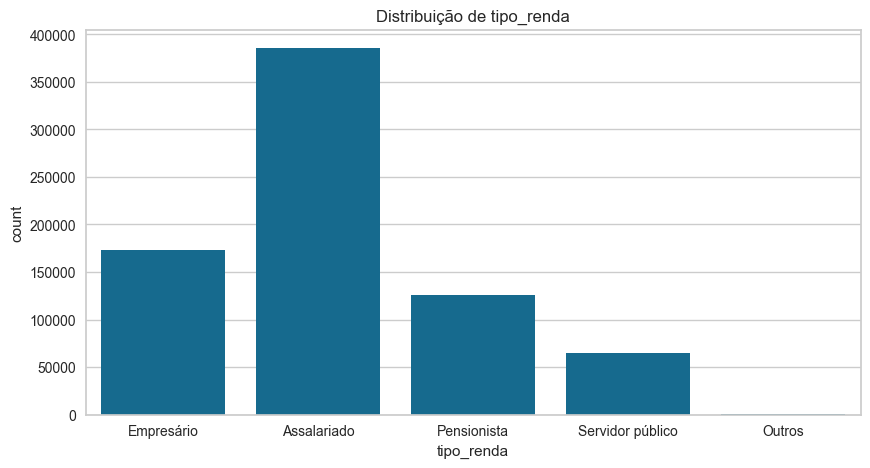

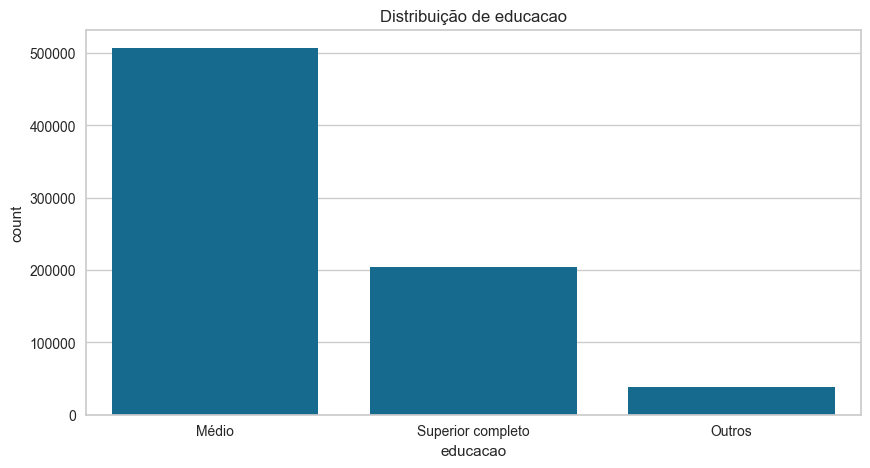

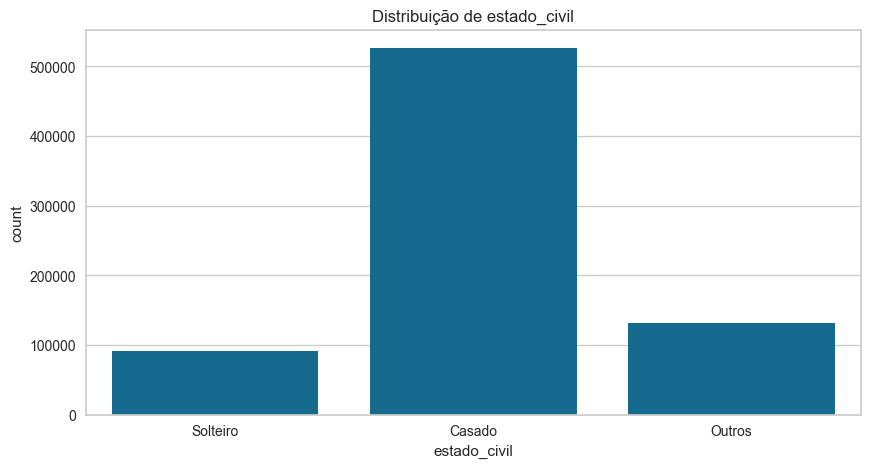

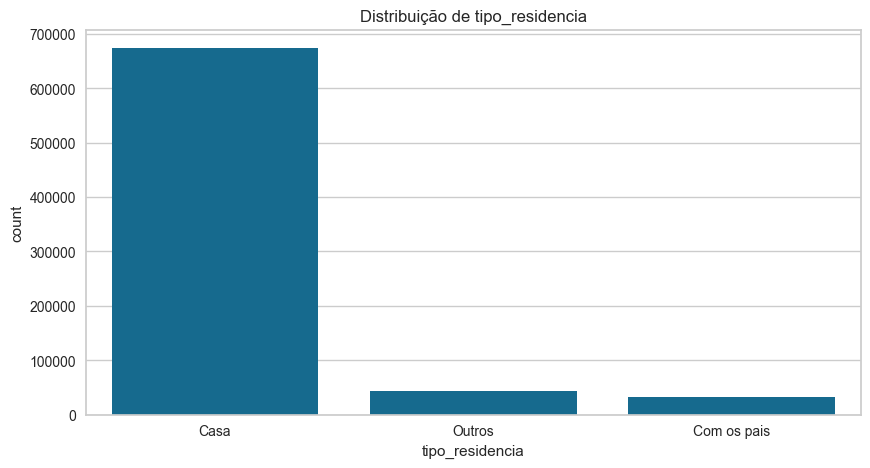

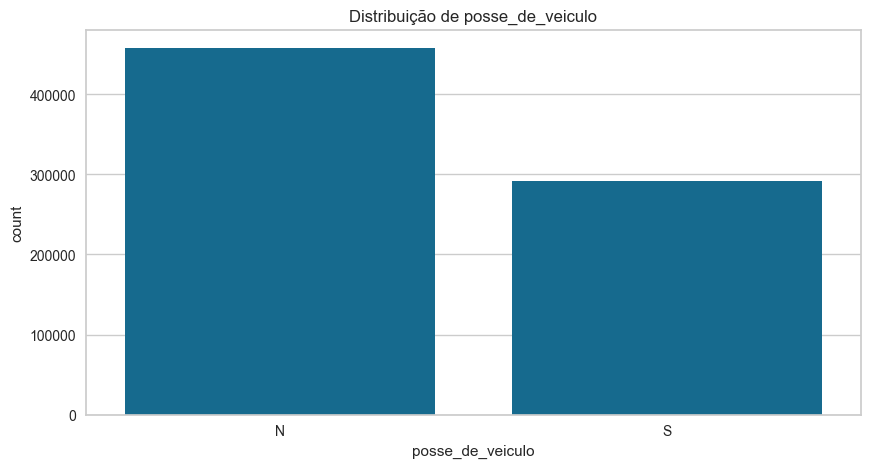

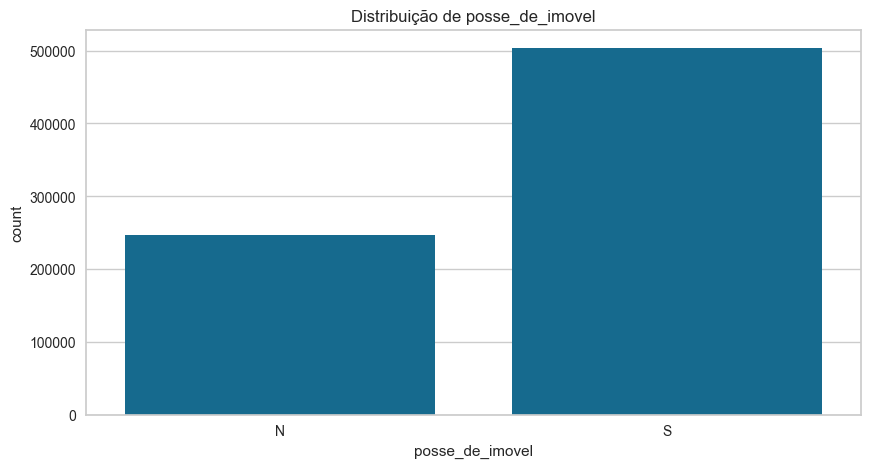

In [20]:
categorical_vars = ['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'posse_de_veiculo', 'posse_de_imovel']

for var in categorical_vars:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x=var)
    plt.title(f'Distribuição de {var}')
    plt.show()

### Verificando a Proporção de Inadimplentes por Categoria

In [21]:
for var in categorical_vars:
    contingency = pd.crosstab(df[var], df['mau'])
    contingency['Proporção de Inadimplentes'] = contingency[True] / (contingency[True] + contingency[False])
    print(contingency)
    print("\n")

mau    False   True  Proporção de Inadimplentes
sexo                                           
F     463950  40630                    0.080522
M     227407  18013                    0.073397


mau                False   True  Proporção de Inadimplentes
tipo_renda                                                 
Assalariado       354527  31213                    0.080917
Empresário        159508  13204                    0.076451
Outros               346     15                    0.041551
Pensionista       115825  10440                    0.082683
Servidor público   61151   3771                    0.058085


mau                 False   True  Proporção de Inadimplentes
educacao                                                    
Médio              466106  40730                    0.080361
Outros              35567   3291                    0.084693
Superior completo  189684  14622                    0.071569


mau            False   True  Proporção de Inadimplentes
estado_civil         

### Visualizando a Proporção de Inadimplentes por Categoria (2)

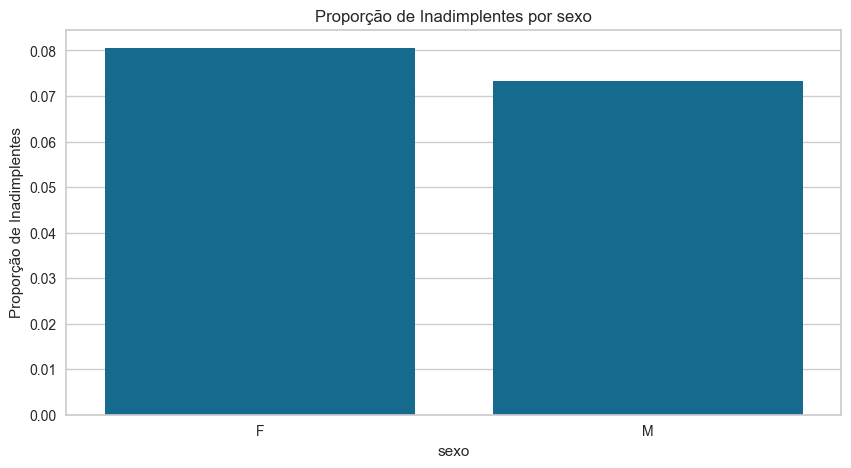

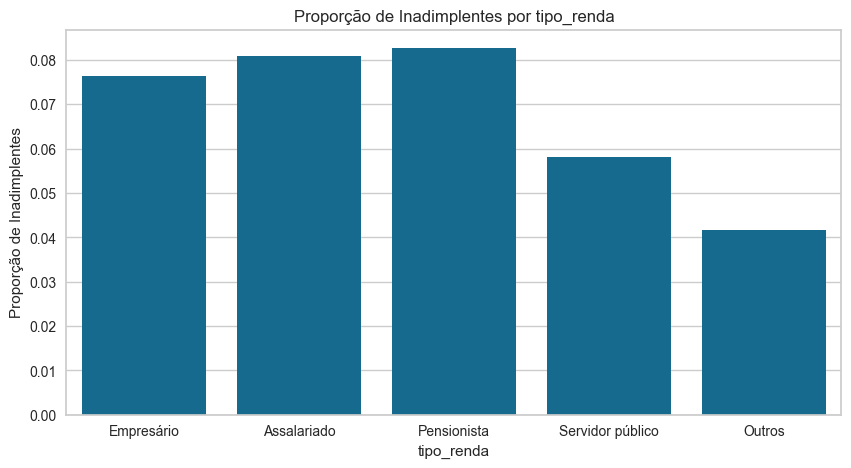

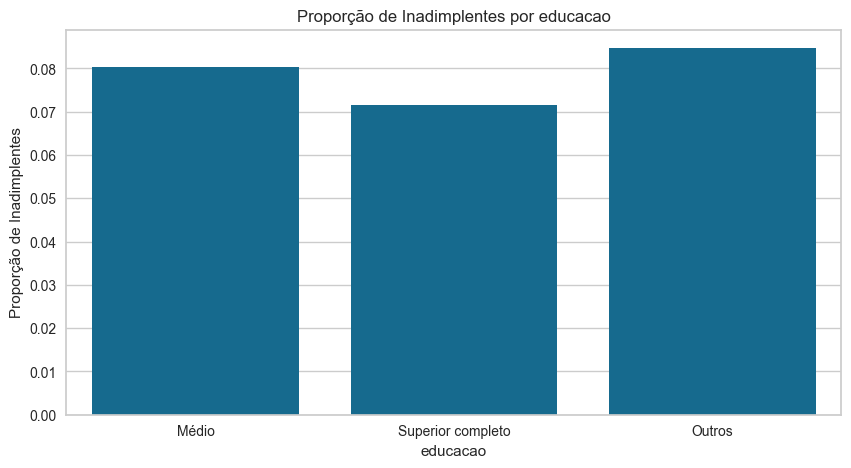

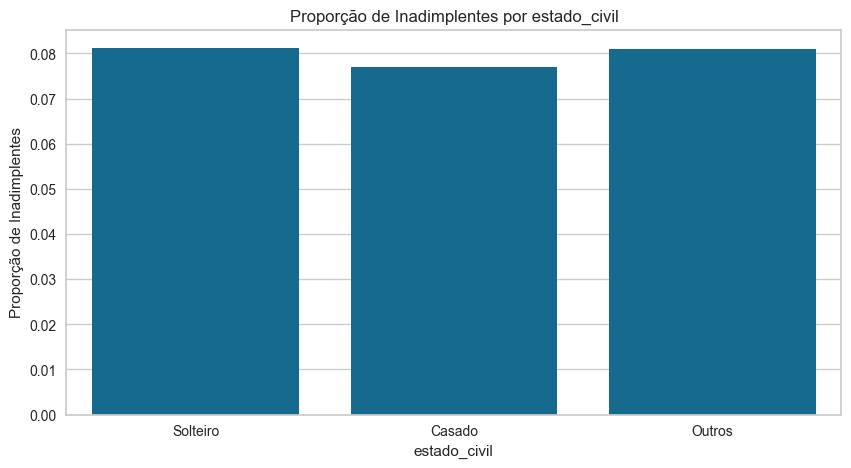

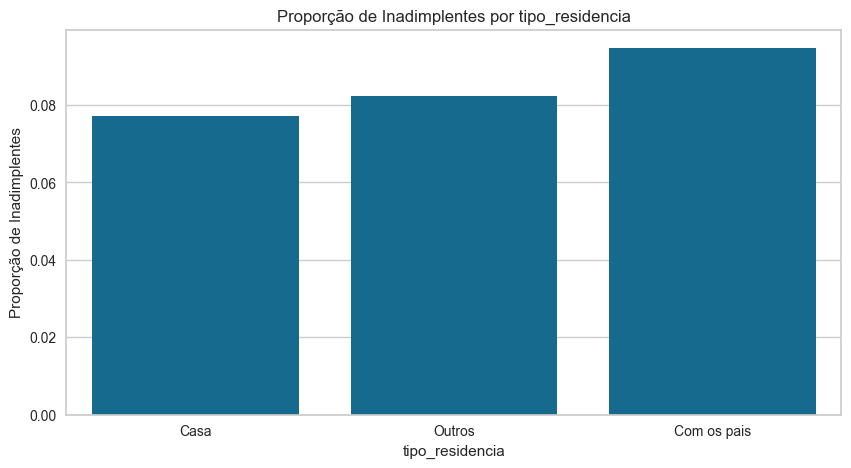

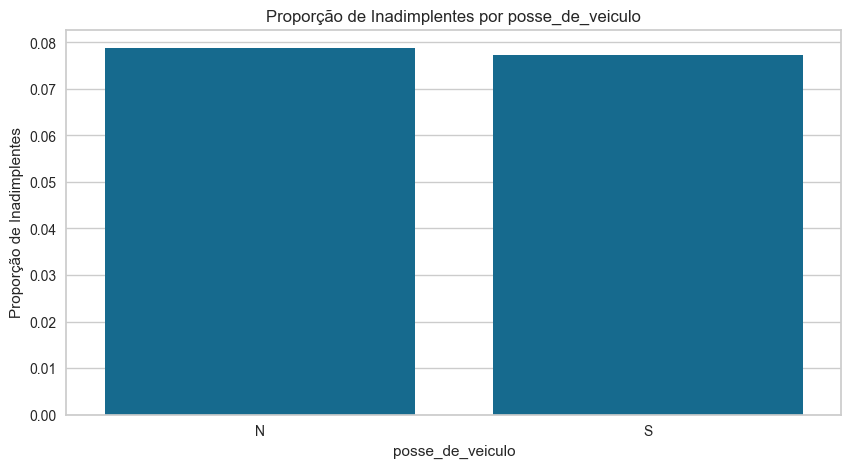

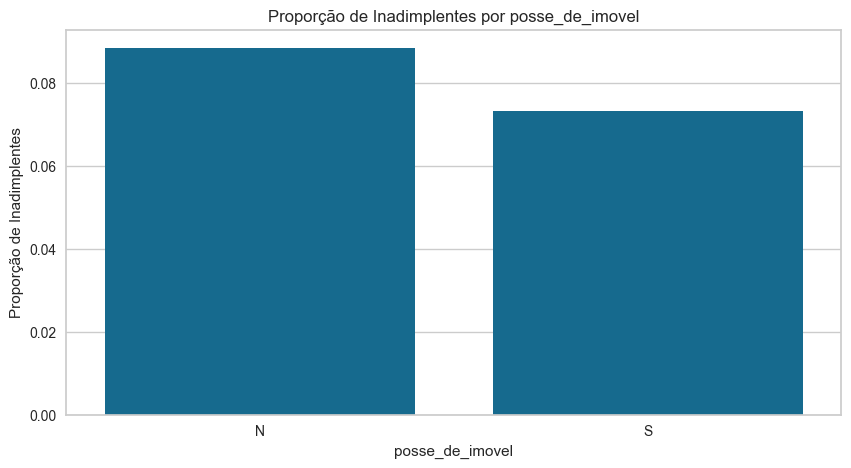

In [22]:
for var in categorical_vars:
    plt.figure(figsize=(10,5))
    sns.barplot(data=df, x=var, y='mau', errorbar=None)
    plt.title(f'Proporção de Inadimplentes por {var}')
    plt.ylabel('Proporção de Inadimplentes')
    plt.show()

### Executando Teste Estatístico

In [23]:
from scipy.stats import chi2_contingency

for var in categorical_vars:
    contingency = pd.crosstab(df[var], df['mau'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f'Variável {var} - p-valor: {p:.4f}')

Variável sexo - p-valor: 0.0000
Variável tipo_renda - p-valor: 0.0000
Variável educacao - p-valor: 0.0000
Variável estado_civil - p-valor: 0.0000
Variável tipo_residencia - p-valor: 0.0000
Variável posse_de_veiculo - p-valor: 0.0157
Variável posse_de_imovel - p-valor: 0.0000


<div style="background-color: #FFF1E0">

# Interpretação dos dados acima

### Os resultados apresentados mostram a proporção de inadimplentes para diferentes categorias.

**Sexo**<br>

- Mulheres (F) têm uma proporção de inadimplência de 8.05%.
- Homens (M) têm uma proporção de inadimplência de 7.34%.

**Tipo de Renda**

- Assalariados têm uma proporção de inadimplência de 8.09%.
- Empresários têm uma proporção de inadimplência de 7.65%.
- Outros têm uma proporção de inadimplência de 4.16%.
- Pensionistas têm uma proporção de inadimplência de 8.27%.
- Servidores públicos têm uma proporção de inadimplência de 5.81%.

**Educação**

- Nível Médio têm uma proporção de inadimplência de 8.04%.
- Outros têm uma proporção de inadimplência de 8.47%.
- Superior completo têm uma proporção de inadimplência de 7.16%.

**Estado Civil**

- Casados têm uma proporção de inadimplência de 7.70%.
- Outros têm uma proporção de inadimplência de 8.10%.
- Solteiros têm uma proporção de inadimplência de 8.12%.

**Tipo de Residência**

- Casa têm uma proporção de inadimplência de 7.71%.
- Com os pais têm uma proporção de inadimplência de 9.47%.
- Outros têm uma proporção de inadimplência de 8.22%.

**Posse de Veículo:**

- Sem veículo (N) têm uma proporção de inadimplência de 7.88%.
- Com veículo (S) têm uma proporção de inadimplência de 7.73%.

**Posse de Imóvel**

- Sem imóvel (N) têm uma proporção de inadimplência de 8.85%.
- Com imóvel (S) têm uma proporção de inadimplência de 7.32%.

Todos os p-valores fornecidos são menores que 0.05, exceto para a variável posse_de_veiculo, onde o p-valor é marginalmente maior que 0.01, ainda significativo, mas menos do que as outras variáveis.

Isso sugere que todas as variáveis apresentadas têm uma associação estatisticamente significativa com a inadimplência, mas a força dessa associação varia entre as variáveis. Por exemplo, o tipo de residência "Com os pais" tem a maior proporção de inadimplência (9.47%), enquanto "Servidor público" no tipo de renda tem a menor proporção de inadimplência (5.81%).

</div>

### Preparando os Dados, Treinamento e Avaliação do Modelo de Regressão Logística

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Dividindo os dados em conjuntos de treinamento e teste
X = df[['sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'posse_de_veiculo', 'posse_de_imovel']]
y = df['mau']

# Codificando variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalando as variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicando o modelo de regressão logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Fazendo previsões
y_pred = logreg.predict(X_test)

# Avaliando o modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# Avaliando a significância das variáveis
X_train_sm = sm.add_constant(X_train)
logit_model = Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

[[207545      0]
 [ 17455      0]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    207545
        True       0.00      0.00      0.00     17455

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.89    225000

AUC-ROC: 0.5
Optimization terminated successfully.
         Current function value: 0.274026
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               525000
Model:                          Logit   Df Residuals:                   524986
Method:                           MLE   Df Model:                           13
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                0.003455
Time:                        17:50:34   Log-Likelihood:            -1.4386e+05
converged:                       True   LL-Null: 

### Calculando a Probabilidade de Inadimplência de um Cliente

In [25]:
def calcular_probabilidade(x):
    # Coeficientes do modelo
    betas = [-2.4749, -0.0588, -0.0232, -0.0104, 0.0141, -0.0971, 0.0091, -0.0468, 0.0106, 0.0174, 0.0375, 0.0071, 0.0218, -0.0969]
    
    # Calculando o log-odds
    log_odds = betas[0] + sum([b*x[i] for i, b in enumerate(betas[1:])])
    
    # Calculando a probabilidade
    p = np.exp(log_odds) / (1 + np.exp(log_odds))
    
    return p

# Exemplo de uso:
# Suponha que temos um cliente com os seguintes valores para x1, x2, ..., x13:
cliente = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

probabilidade = calcular_probabilidade(cliente)
print(f"A probabilidade do cliente ser 'mau' é: {probabilidade:.4f}")

A probabilidade do cliente ser 'mau' é: 0.0262


<div style="background-color: #FFF1E0">

Com base nos resultados do modelo de regressão logística fornecidos anteriormente, podemos identificar a significância de cada variável observando o valor p (P>|z|):

x3 tem um valor p de 0.121, que é maior que o limite comum de 0.05.
x6 tem um valor p de 0.071, que está próximo ao limite, mas tecnicamente ainda é maior que 0.05.
x11 tem um valor p de 0.165, que é maior que o limite comum de 0.05.
Variáveis com valores p maiores que 0.05 geralmente são consideradas não significativas em um modelo estatístico.

**Justificação para variáveis não significativas**

x3: O valor p acima de 0.05 sugere que a variável x3 pode não ter uma relação significativa com a variável dependente (mau). Pode ser que x3 simplesmente não seja relevante para a previsão de um cliente ser "mau".

x6: Apesar de o valor p estar próximo do limite, ainda indica que a variável pode não ser crucial para o modelo. Pode haver variabilidade que x6 não consegue explicar ou pode ser redundante em relação a outras variáveis.

x11: O valor p para x11 indica que pode não ter uma relação forte ou significativa com a variável dependente.
</div>

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [26]:
# Função para calcular KS e Gini
def calculate_ks_gini(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    ks = max(tpr - fpr)
    gini = (2 * auc(fpr, tpr)) - 1
    return ks, gini

# Para o conjunto de treinamento
y_train_probs = logreg.predict_proba(X_train)[:,1]
ks_train, gini_train = calculate_ks_gini(y_train, y_train_probs)
print(f"Treinamento - Acurácia: {logreg.score(X_train, y_train):.4f}")
print(f"Treinamento - KS: {ks_train:.4f}")
print(f"Treinamento - Gini: {gini_train:.4f}")

print("\n")

# Para o conjunto de teste (out of time)
y_test_probs = logreg.predict_proba(X_test)[:,1]
ks_test, gini_test = calculate_ks_gini(y_test, y_test_probs)
print(f"Teste (Out of Time) - Acurácia: {logreg.score(X_test, y_test):.4f}")
print(f"Teste (Out of Time) - KS: {ks_test:.4f}")
print(f"Teste (Out of Time) - Gini: {gini_test:.4f}")

Treinamento - Acurácia: 0.9215
Treinamento - KS: 0.0675
Treinamento - Gini: 0.0920


Teste (Out of Time) - Acurácia: 0.9224
Teste (Out of Time) - KS: 0.0632
Teste (Out of Time) - Gini: 0.0910


<div style="background-color: #FFF1E0">O modelo tem uma acurácia muito boa, mas os valores de KS e Gini sugerem que pode ter dificuldades em diferenciar bem entre os bons e maus clientes. Isso pode ser devido a várias razões, como um desequilíbrio na distribuição das classes, características insuficientes ou a necessidade de se ajustar ou otimizar ainda mais o modelo.</div>

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [27]:
# Identificando valores nulos
nulos = df.isnull().sum()
print(nulos[nulos > 0])

Series([], dtype: int64)


In [28]:
# Listando colunas numéricas e categóricas
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Criando transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Criando e avaliando o pipeline completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [29]:
# Identificando outliers com o Método do Intervalo Interquartil (IQR)

def detect_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

In [30]:
# Identificando outliers com o Método Z-score

def detect_outliers_zscore(data, column_name, threshold=3):
    mean = np.mean(data[column_name])
    std = np.std(data[column_name])

    z_scores = [(x - mean) / std for x in data[column_name]]
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

In [31]:
# Visualizando com Boxplot
def plot_boxplot(data, column_name):
    sns.boxplot(x=data[column_name])
    plt.title(f'Boxplot for {column_name}')
    plt.show()

### Detecção e Visualização de Outliers na Variável 'Renda'

Outliers usando IQR: Empty DataFrame
Columns: [data_ref, sexo, posse_de_veiculo, posse_de_imovel, qtd_filhos, tipo_renda, educacao, estado_civil, tipo_residencia, idade, tempo_emprego, qt_pessoas_residencia, renda, mau]
Index: []
Outliers usando Z-Score:          data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
33345  2015-01-01    F                N               S         0.0   
33520  2015-01-01    F                S               S         1.0   
33126  2015-01-01    F                N               S         0.0   
33748  2015-01-01    F                S               S         0.0   
31970  2015-01-01    F                N               N         0.0   
...           ...  ...              ...             ...         ...   
715991 2016-03-01    F                N               S         0.0   
715973 2016-03-01    M                S               S         1.0   
716885 2016-03-01    F                N               S         0.0   
717095 2016-03-01    F             

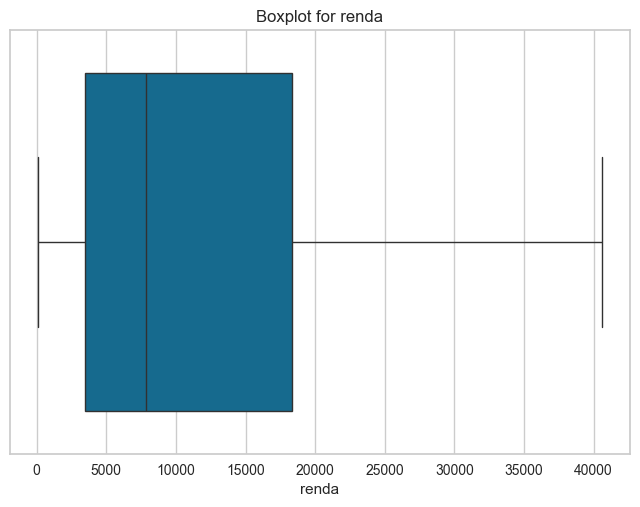

In [32]:
outliers_iqr = detect_outliers_iqr(df, "renda")
print("Outliers usando IQR:", outliers_iqr)

outliers_zscore = detect_outliers_zscore(df, "renda")
print("Outliers usando Z-Score:", outliers_zscore)

plot_boxplot(df, "renda")

In [33]:
# Removendo outliers usando Z-Score
df_no_outliers_zscore = df[~df.index.isin(outliers_zscore.index)]

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

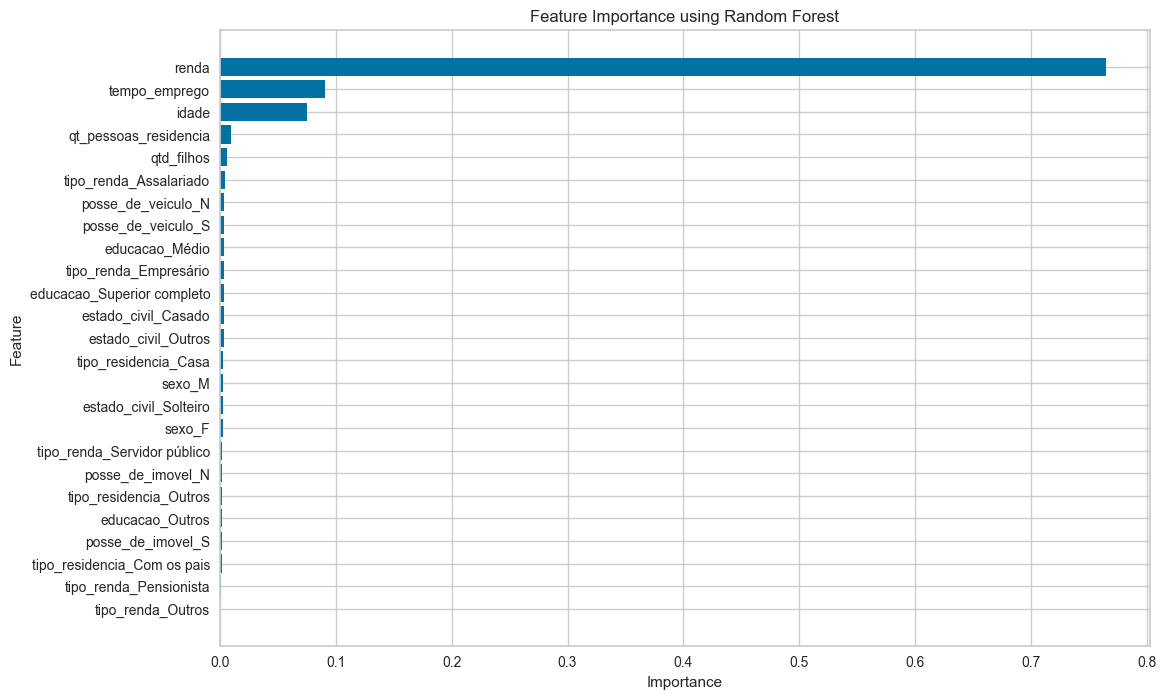

In [34]:
# Removendo a coluna alvo e outras não numéricas/irrelevantes para formar o conjunto de características
X = df_no_outliers_zscore.drop(['mau', 'data_ref'], axis=1)
y = df_no_outliers_zscore['mau']

# Transformando variáveis categóricas em numéricas usando pd.get_dummies
X = pd.get_dummies(X)

# Criando o modelo
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Obtendo importância das variáveis
feature_importance = clf.feature_importances_

# Criando um DataFrame para visualização
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Ordenando o DataFrame pela importância
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das variáveis
plt.figure(figsize=(12, 8))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis()  # Para mostrar a característica mais importante no topo
plt.show()

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

Variância explicada por cada componente: [0.14823438 0.09842774 0.08331356 0.08289565 0.0704469 ]


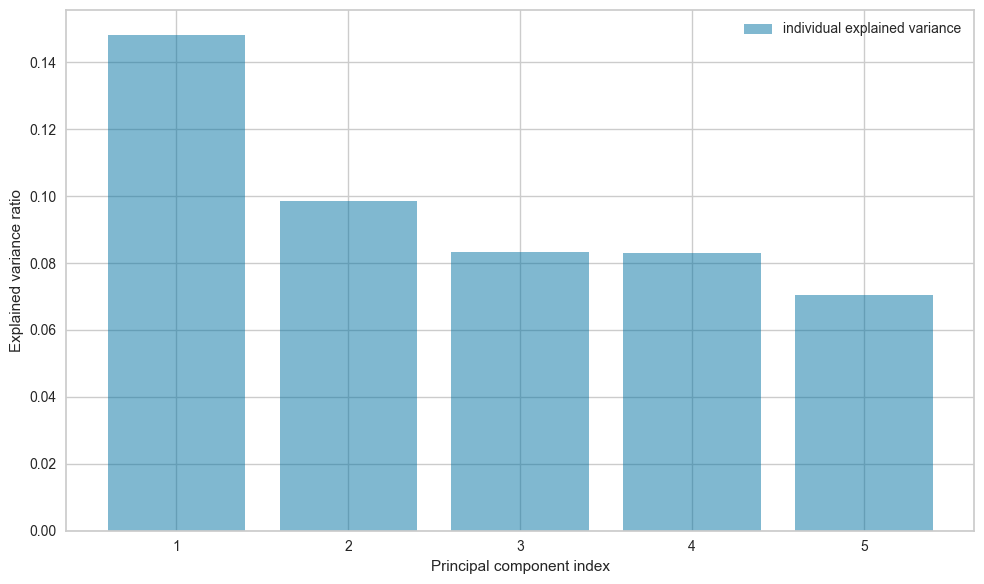

In [35]:
# Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando PCA aos dados padronizados
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Mostrando a variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada por cada componente: {explained_variance}")

# Visualizando os componentes principais em relação à variância explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<div style="background-color: #FFF1E0">

O gráfico mostra a variância explicada por cada um dos primeiros cinco componentes principais. O primeiro componente explica aproximadamente 14.8% da variância, o segundo cerca de 9.8%, e assim por diante.

Esses resultados indicam que, enquanto o primeiro componente é o mais informativo, os componentes subsequentes também carregam informações significativas sobre os dados. 
    
</div>

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [36]:
# Listand para transformação
colunas_categoricas = ["sexo", "posse_de_veiculo", "posse_de_imovel", "tipo_renda", 
                       "educacao", "estado_civil", "tipo_residencia"]

# Usando get_dummies() para transformar as colunas
df_dummies = pd.get_dummies(df, columns=colunas_categoricas)

# Mostrando as primeiras linhas do dataframe transformado
df_dummies.head()

,data_ref,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,...,tipo_renda_Servidor público,educacao_Médio,educacao_Outros,educacao_Superior completo,estado_civil_Casado,estado_civil_Outros,estado_civil_Solteiro,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Outros
0,2015-01-01,0.0,43,6.873973,1.0,2515.39,False,1,0,1,...,0,1,0,0,0,0,1,1,0,0
33328,2015-01-01,1.0,41,8.134247,3.0,4979.48,False,0,1,0,...,0,1,0,0,1,0,0,1,0,0
33329,2015-01-01,0.0,26,1.424658,1.0,1285.25,False,1,0,1,...,0,0,0,1,0,0,1,1,0,0
33330,2015-01-01,1.0,37,15.449315,3.0,14473.15,False,0,1,1,...,0,0,1,0,1,0,0,1,0,0
33331,2015-01-01,1.0,30,0.369863,3.0,1366.63,False,1,0,1,...,0,1,0,0,1,0,0,1,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [37]:
# Substituindo nulos
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Remoção de outliers (usando o StandardScaler)
# A função de remoção de outliers foi incorporada no pipeline acima através do StandardScaler

# Aplicando o PCA
pca = PCA(n_components=5)

# Criando os dummies
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Unindo tudo em um único ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Criando o pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])

X = df.drop(columns='mau')  # Excluindo a coluna alvo para realizar o processamento
y = df['mau']  # Nova coluna alvo

# Ajustando e transformando o pipeline:
X_transformed = pipeline.fit_transform(X)

In [38]:
print(f"Shape original: {df.shape}")
print(f"Shape após transformação: {X_transformed.shape}")

Shape original: (750000, 14)
Shape após transformação: (750000, 5)


In [39]:
# Variância explicada por cada componente principal 
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_
print(f"Variância explicada por cada componente: {explained_variance}")

Variância explicada por cada componente: [0.28021097 0.17599716 0.10733211 0.07218787 0.06986168]


In [40]:
# Visualizando dados tranformados
X_transformed_df = pd.DataFrame(X_transformed)
X_transformed_df.head()

,0,1,2,3,4
0,-1.320747,-1.150008,0.207550,-1.280213,-0.264011
1,1.485635,0.238004,-0.448797,0.629574,-1.106505
2,-0.246281,-2.480686,1.441219,-1.402278,0.273153
3,1.102130,2.163648,0.061687,-0.794264,-1.005763
4,1.979971,-1.551600,-0.458851,-0.362845,0.946117


In [41]:
# Calculando e exibindo o número total de valores nulos presentes no DataFrame, após transformações de dados
null_counts = X_transformed_df.isnull().sum().sum()
print(f"Quantidade de valores nulos após transformação: {null_counts}")

Quantidade de valores nulos após transformação: 0


### Dividindo os dados em conjuntos de treino e teste, treinando um modelo de Regressão Logística com o conjunto de treino, fazendo previsões no conjunto de teste e calculando a acurácia do modelo.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

Acurácia do modelo: 0.9224


<div style="background-color: #FFF1E0">
    
# Vamos interpretar os resultados:

### Shape:

O shape original do seu conjunto de dados era (750000, 15), o que significa que você tinha 750.000 amostras e 15 características.
O shape após a transformação é (750000, 5), o que indica que você ainda tem 750.000 amostras (isso é bom, significa que nenhuma amostra foi perdida), mas agora tem apenas 5 características. Isso é esperado porque você aplicou o PCA e reduziu a dimensionalidade para 5 componentes.
### Variância explicada pelo PCA:

Os 5 componentes explicam, respectivamente, cerca de 28.2%, 18.3%, 10.8%, 7.1%, e 6.1% da variância nos dados. Juntos, esses cinco componentes explicam mais de 64% da variância total, o que é um bom sinal, especialmente considerando que você reduziu significativamente a dimensionalidade.
### Inspeção Visual:

A visualização das primeiras linhas do conjunto de dados transformado mostra que os valores foram padronizados (a partir da etapa de escala) e transformados pelo PCA. Os valores que você vê não são imediatamente interpretáveis, mas isso é esperado com a análise de componentes principais.
### Valores Nulos:

A ausência de valores nulos após a transformação é um bom sinal, indicando que as etapas de substituição de nulos e outras transformações foram bem-sucedidas.
### Acurácia do Modelo:

Uma acurácia de 92,20% com um modelo simples de regressão logística é muito boa. Isso sugere que o pré-processamento foi eficaz e que os dados transformados são úteis para modelagem.</div>

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [43]:
# Carregando a base

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [44]:
# Inicializando o ambiente PyCaret. Isso irá realizar o pré-processamento automático.
clf1 = setup(data = df, target = 'mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Ordinal features,3
8,Numeric features,6
9,Date features,1


### Criando o modelo LightGBM

In [45]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7706,0.0248,0.5231,0.0474,0.0406,0.1012
1,0.9222,0.7879,0.0292,0.5479,0.0555,0.0480,0.1132
2,0.9223,0.7796,0.0270,0.5722,0.0516,0.0449,0.1121
3,0.9222,0.7817,0.0258,0.5550,0.0493,0.0427,0.1073
4,0.9219,0.7838,0.0236,0.5105,0.0452,0.0385,0.0971
5,0.9227,0.7768,0.0295,0.6142,0.0563,0.0494,0.1225
6,0.9226,0.7830,0.0287,0.6020,0.0549,0.0481,0.1194
7,0.9217,0.7790,0.0256,0.4861,0.0486,0.0411,0.0977
8,0.9220,0.7792,0.0263,0.5217,0.0501,0.0429,0.1039


### Avaliando o desempenho do Modelo LightGBM

In [46]:
evaluate_model(lightgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Visualizando a importância das características do Modelo LightGBM

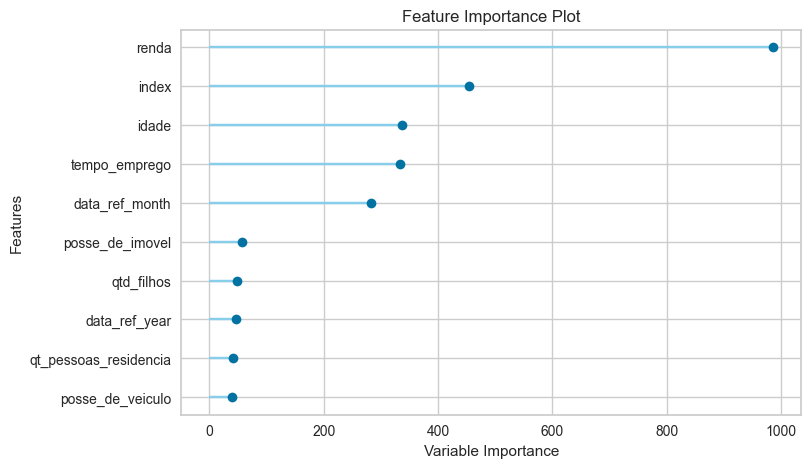

In [47]:
plot_model(lightgbm_model, plot='feature')

### Finalizando o modelo LightGBM

In [48]:
final_lightgbm = finalize_model(lightgbm_model)

### Salvando o Modelo LightGBM finalizado

In [49]:
save_model(final_lightgbm, 'final_lightgbm_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_ra